## OPT Trout processing
* MAG 0.5, C mount.
* embedded in 1.5%, 2ECI
* WL transmission, 590nm LP detections
* 400 steps and undersampling

In [1]:
import sys
import os
from pathlib import Path
import gc
import psutil
from time import perf_counter

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

from tqdm import tqdm
from scipy.ndimage import variance
from IPython.display import display

import tomopy as tom
from tomopy.recon.rotation import find_center_vo, find_center

import utils_opt as u
from napari_opt_handler.corrections import Correct
from data_loader import OptLoader

%load_ext autoreload
%autoreload 2

## Transmission LP590

In [3]:
root_folder = Path('/opt/shared/opt_paper_david/raw_data/')

In [4]:
folder = root_folder.joinpath('2024_08_01-transmission/2024_08_01-11-45-31_tr_400')
folder_corr = root_folder.joinpath('2024_08_01-transmission')

dflat = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-01-01_flat_field.tiff')), cv2.IMREAD_UNCHANGED)
ddark = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-02-29_dark_field.tiff')), cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')), cv2.IMREAD_UNCHANGED)

In [5]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:03<00:00, 102.13it/s]


In [6]:
u.memory_profile()

                    types |   # objects |   total size
========================= | =========== | ============
            numpy.ndarray |         319 |      2.36 GB
                      str |      182528 |     37.80 MB
                     dict |       88937 |     29.70 MB
                     code |       63181 |     10.74 MB
                     type |        8274 |      7.66 MB
                    tuple |       79311 |      4.79 MB
                     list |       24749 |      2.71 MB
                      set |        7184 |      2.64 MB
                  weakref |       15487 |      1.06 MB
              abc.ABCMeta |         784 |    837.70 KB
  collections.OrderedDict |         869 |    832.15 KB
          sip.wrappertype |         674 |    704.30 KB
                frozenset |        1953 |    638.21 KB
      function (__init__) |        4205 |    591.33 KB
             sip.enumtype |         559 |    585.20 KB


In [7]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1, description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1416, min=0, max=width, step=1, description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1, description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2047, min=0, max=height, step=1, description='y1:', disabled=False)

In [8]:
# 340, 1180, y1: 1400
display(ix0), display(ix1)
display(iy0), display(iy1)

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1416, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2047, description='y1:', max=2048)

(None, None)

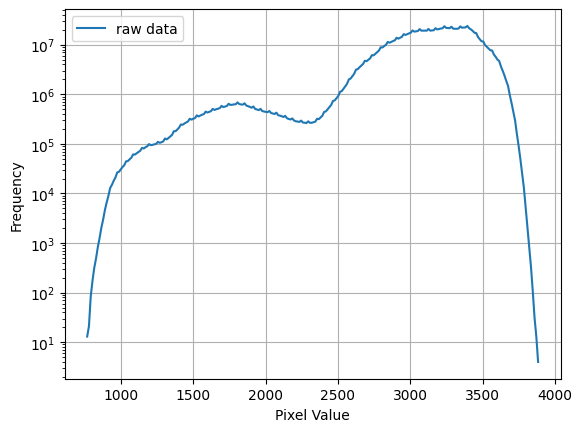

In [9]:
hists = u.histogram(opt.data, 'raw data')
u.plot_histograms(hists)

In [10]:
cmap=plt.cm.Greys_r

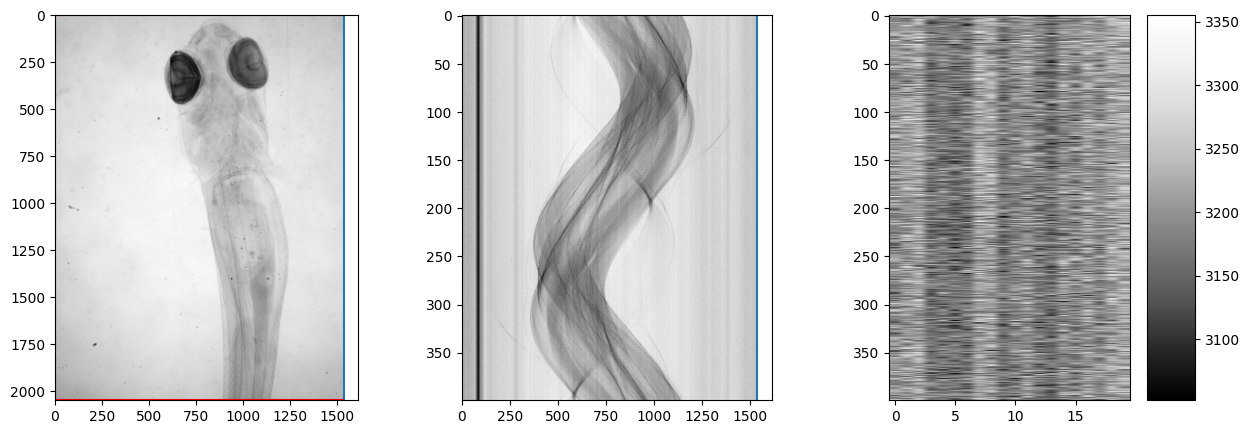

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# --- subplot 1 ---
axs[0].imshow(opt.data[min(100, n_steps-1)], cmap=cmap)
axs[0].set_aspect(1)
axs[0].vlines([ix0.value, ix1.value], 0, height-1)
axs[0].hlines([iy0.value, iy1.value], 0, width-1, colors='r')

# --- subplot 2 ---
axs[1].imshow(opt.data[:, height//2, :], cmap=cmap)
axs[1].set_aspect(5)
axs[1].vlines([ix0.value, ix1.value], 0, n_steps-1)

# --- subplot 3 ---
im = axs[2].imshow(opt.data[:, height//2, :20], cmap=cmap)
axs[2].set_aspect(0.08)
fig.colorbar(im, ax=axs[2], aspect=8)

plt.show()

In [12]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

### Corrections

In [13]:
try:
    del Corr
except:
    pass
gc.collect
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)
Corr.set_bright(bright=dflat)

#### Dark-Bright correction

In [15]:
gc.collect()
data_corr = Corr.correct_dark_bright(
                data, modality='Transmission', useDark=True, useBright=True)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

Overflows 0.17, 1.14, clipping to 0-1.


After Correction max: 65535, min: 11255.


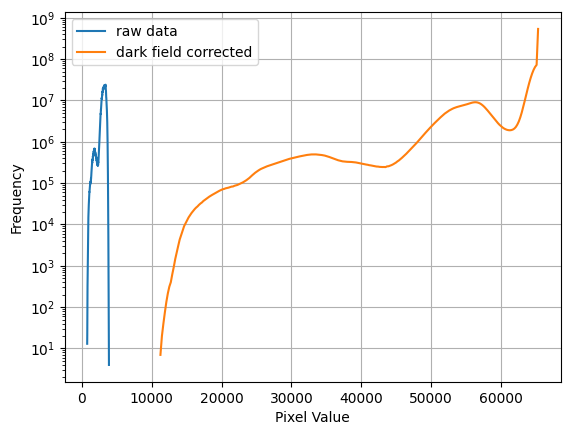

In [16]:
hists = u.histogram(data_corr, hist_dict=hists, name='dark field corrected')
u.plot_histograms(hists)

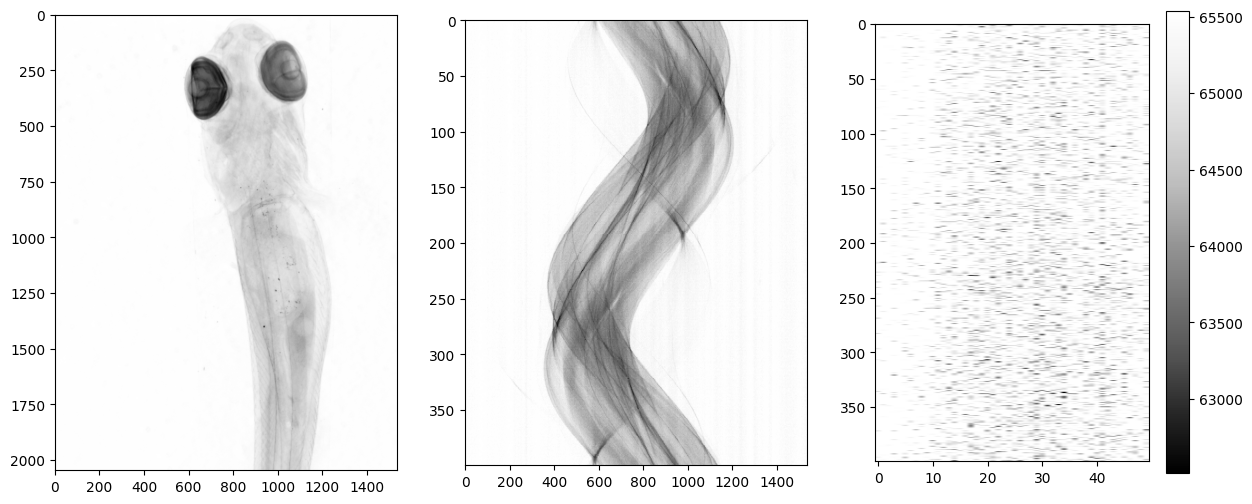

In [17]:
plt.figure(figsize=(15, 6))
plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
plt.subplot(132), plt.imshow(data_corr[:, height//2, :], cmap=cmap), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
plt.show()

### Intensity correction

In [18]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='No',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', index=1, options=('Yes', 'No'), rows=2, value='No')

In [19]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    if data_corr.dtype != np.float16:
        print(f'Converting data_corr from {data_corr.dtype} to float16')
        data_corr = data_corr.astype(np.float16)

    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])

    plt.figure(figsize=(15, 6))
    plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
    plt.subplot(132), plt.imshow(data_corr[:, height//2, :], cmap=cmap), plt.gca().set_aspect(5)
    plt.subplot(133), plt.imshow(data_corr[:, height//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
    plt.show()
    

### Stride in rows
- reduce dataset

In [20]:
strideRows = widgets.BoundedIntText(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Reduce Rows:',
    disabled=False
)

display(strideRows)

BoundedIntText(value=1, description='Reduce Rows:', max=500, min=1)

In [22]:
if strideRows.value != 1:
    data_corr = data_corr[:, ::strideRows.value, :]
data_corr.shape, data_corr.dtype

((400, 2047, 1536), dtype('uint16'))

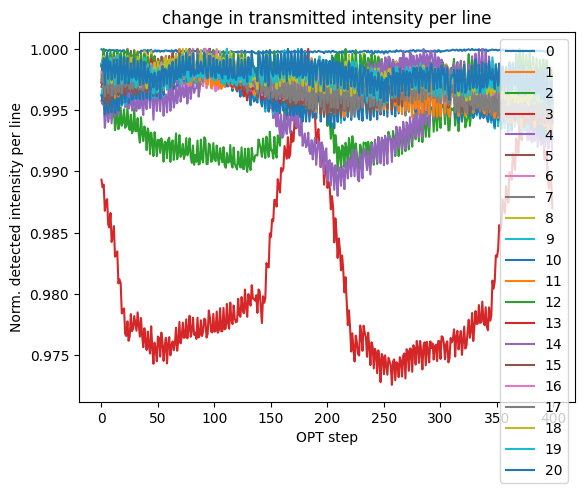

In [23]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
if data_corr.shape[1] < 20:
    # I want to see the variation along the sinogram
    for i, sino in enumerate(meanOverColumns):
        plt.plot(sino/max(sino), label=i)
else:
    for i, sino in enumerate(meanOverColumns[::100]):
        plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
# plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

### -log

In [24]:
logCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='-log?',
                disabled=False
            )

display(logCorr)

Select(description='-log?', options=('Yes', 'No'), rows=2, value='Yes')

Converting data_corr from float32 to float16


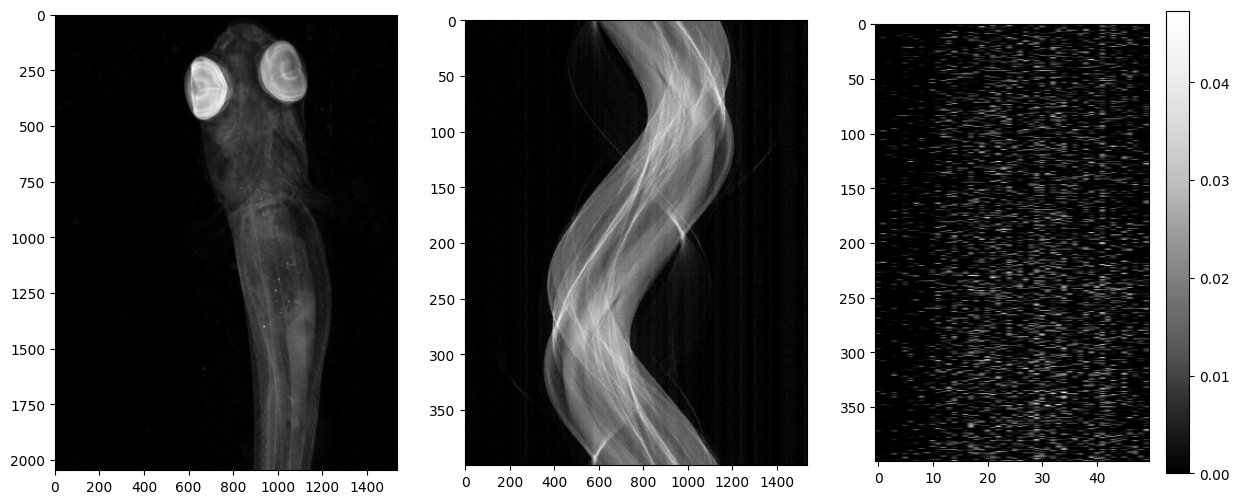

In [25]:
# intensity correction (Without referencing no good for the PL)
if logCorr.value == 'Yes':
    data_corr = tom.minus_log(data_corr, 2)  # two cores
    data_corr = data_corr - np.amin(data_corr)
    
    if data_corr.dtype != np.float16:
        print(f'Converting data_corr from {data_corr.dtype} to float16')
        data_corr = data_corr.astype(np.float16)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(131), plt.imshow(data_corr[min(100, n_steps-1)], cmap=cmap)
    plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :], cmap=cmap), plt.gca().set_aspect(5)
    plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50], cmap=cmap), plt.gca().set_aspect(0.2), plt.colorbar()
    plt.show()

#### Paper figure for the corrections

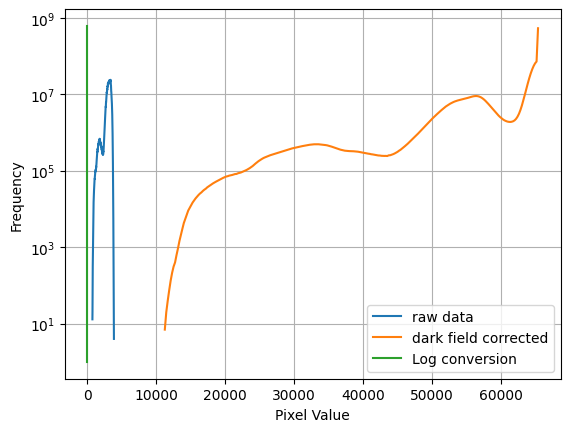

In [26]:
hists = u.histogram(data_corr, hist_dict=hists, name='Log conversion')
u.plot_histograms(hists)

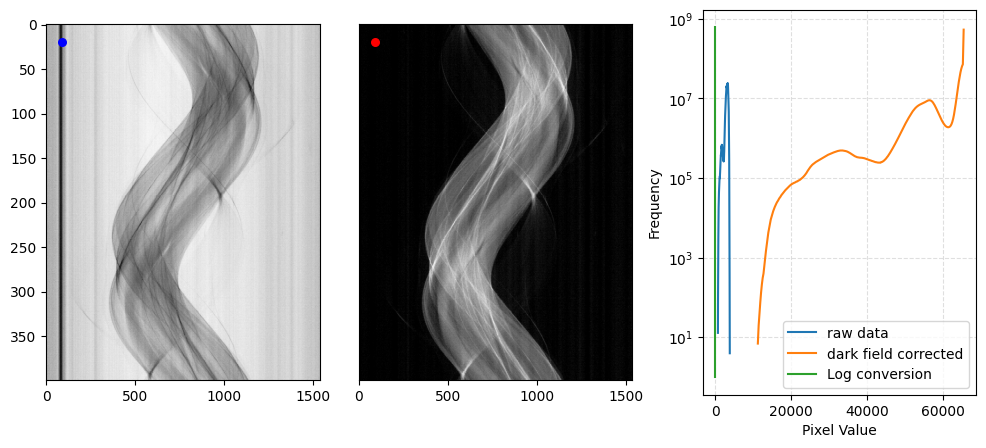

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# --- subplot 1 ---
# axs[0].imshow(opt.data[min(100, n_steps-1)])
axs[0].imshow(opt.data[:, height//2, :], cmap=plt.cm.Greys_r)
axs[0].scatter(90, 20, color="blue", s=30)
axs[0].set_aspect(5)

# --- subplot 2 ---
# axs[1].imshow(data_corr[min(100, n_steps-1)])
axs[1].imshow(data_corr[:, height//2, :], cmap=plt.cm.Greys_r)
axs[1].scatter(90, 20, color="red", s=30)
axs[1].set_aspect(5)
axs[1].set_yticks([])

u.move_horizontal(axs[1], -0.013)

# --- subplot 3 ---
u.plot_histograms_paper(axs[2], hists)

plt.savefig('fig_output/fig1b_tr_corrections.png', dpi=180)
plt.show()

#### Clean the memory

In [28]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


### Stats on the stack

In [29]:
print(f"number of pixels > 4095: {np.sum(data_corr > 4095)}")
print(f'Maximum pixel value: {np.amax(data_corr)}')

# count zeros in data_corr
print(f'Number of pixels with value 0: {np.sum(data_corr == 0)}')

assert np.sum(data_corr < 0) == 0, "Negative pixel values found!"

number of pixels > 4095: 0
Maximum pixel value: 1.76171875
Number of pixels with value 0: 462835211


### Reconstruction setup

In [30]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(np.float16(1.762), np.float16(0.0))

### Finding COR
- this section can be skipped, the correct value of 779 is hardcoded into the next section

In [ ]:
beg = perf_counter()
var_fbp_cuda = []
cors = np.arange(770, 787, 1)

for cor in cors:
    recon_trfrecon_fbp_cudabp_cuda = tom.recon(data_corr[:, 50::100, :],
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.90)

    var_fbp_cuda.append(np.sum([variance(k) for k in recon_fbp_cuda]))
    print(cor, var_fbp_cuda, end='\r')  

end = perf_counter()
print()
print(f"Execution time: {np.round(end-beg, 2)} s")
print('######################')
print(f"index of the maximum variance: {np.argmax(var_fbp_cuda)}, COR value: {cors[np.argmax(var_fbp_cuda)]}")

786 [np.float64(2.4351083456824403e-06), np.float64(2.4575471873807446e-06), np.float64(2.4822433601912053e-06), np.float64(2.5069798981449926e-06), np.float64(2.5316429375581924e-06), np.float64(2.5613667560264726e-06), np.float64(2.5954995521715323e-06), np.float64(2.624809370546346e-06), np.float64(2.6559314739592483e-06), np.float64(2.7071711201642756e-06), np.float64(2.7714183753838983e-06), np.float64(2.786766998497115e-06), np.float64(2.7428650797547666e-06), np.float64(2.6897695559253202e-06), np.float64(2.656741950583334e-06), np.float64(2.6269319132805117e-06), np.float64(2.5943496477035905e-06)]
Execution time: 3.9 s
######################
index of the maximum variance: 11, COR value: 781


#### Plot variance of stack

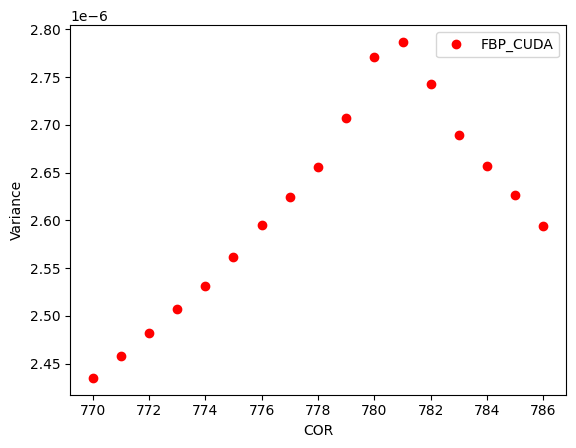

In [53]:
plt.plot(cors, var_fbp_cuda, 'ro', label=options['method'])
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

### Reconstruction

In [31]:
beg=perf_counter()
recon_fbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=781,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.950).astype(np.float16)
end = perf_counter()
print(f"Execution time: {np.round(end-beg, 2)} s")

# clip negative values
recon_fbp_cuda = np.maximum(recon_fbp_cuda, 0)

# del data_corr
gc.collect()

Execution time: 55.1 s


59332

In [32]:
if recon_fbp_cuda.dtype != np.float16:
    print(f'Converting recon_fbp_cuda from {recon_fbp_cuda.dtype} to float16')
    recon_fbp_cuda = recon_fbp_cuda.astype(np.float16)
print(f'reconstruction shape: {recon_fbp_cuda.shape}')
print(f'min-max range of the reconstructed volume: {np.amin(recon_fbp_cuda)} - {np.amax(recon_fbp_cuda)}')
print(f'size of the volume: {sys.getsizeof(recon_fbp_cuda) / 1e9} GB')

reconstruction shape: (2047, 1536, 1536)
min-max range of the reconstructed volume: 0.0 - 0.1114501953125
size of the volume: 9.658957968 GB


min max of reconstructions: 0.0 0.11145


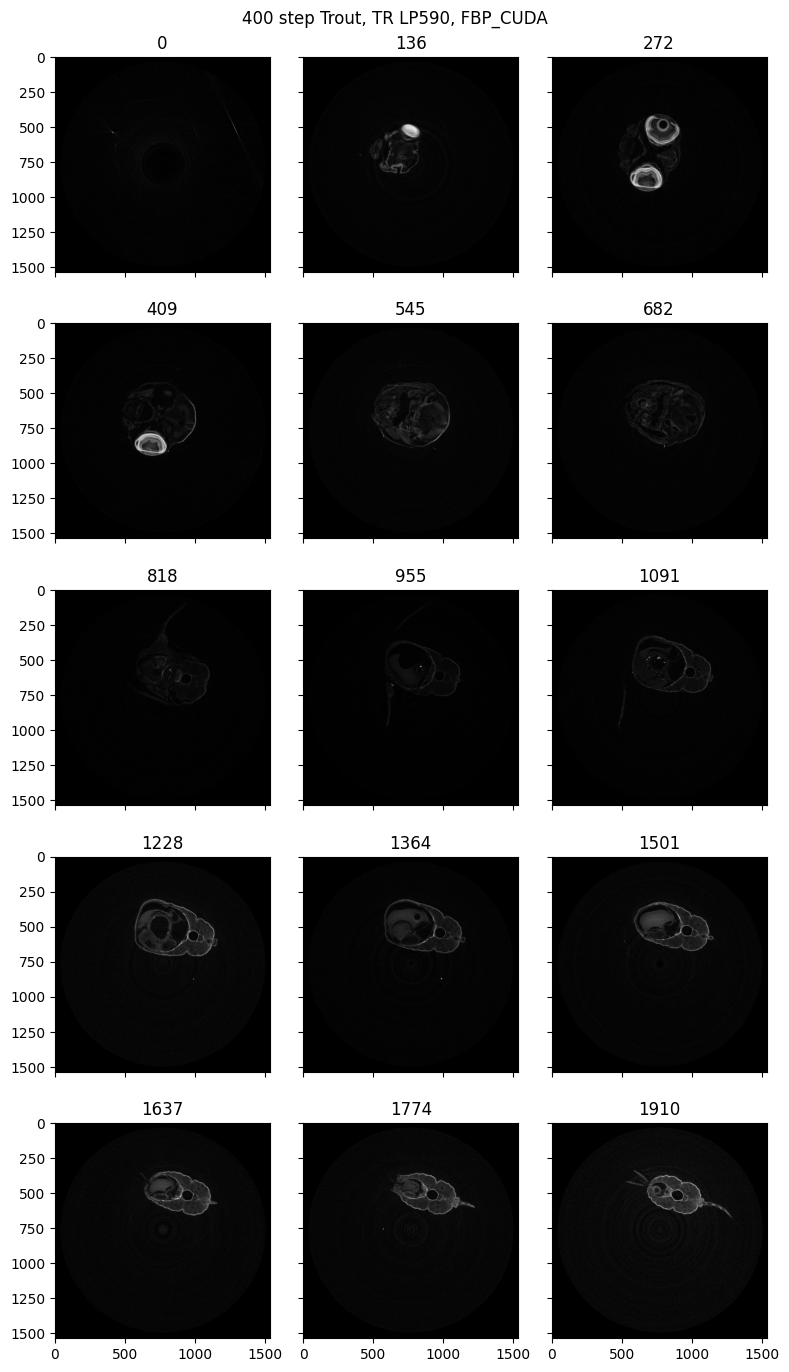

In [33]:
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_fbp_cuda),
      np.amax(recon_fbp_cuda))

for i in range(len(recon_fbp_cuda)):
    
    try:
        line = int(height/15*i)
        ax[i//3, i%3].imshow(recon_fbp_cuda[line], cmap=plt.cm.Greys_r)
        ax[i//3, i%3].set_title(line)
        lineidx.append(line)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('fig_output/0801_trout_fbp-cuda_400_tr_lp590.png', dpi=180)
plt.show()

#### Normalize and saturate

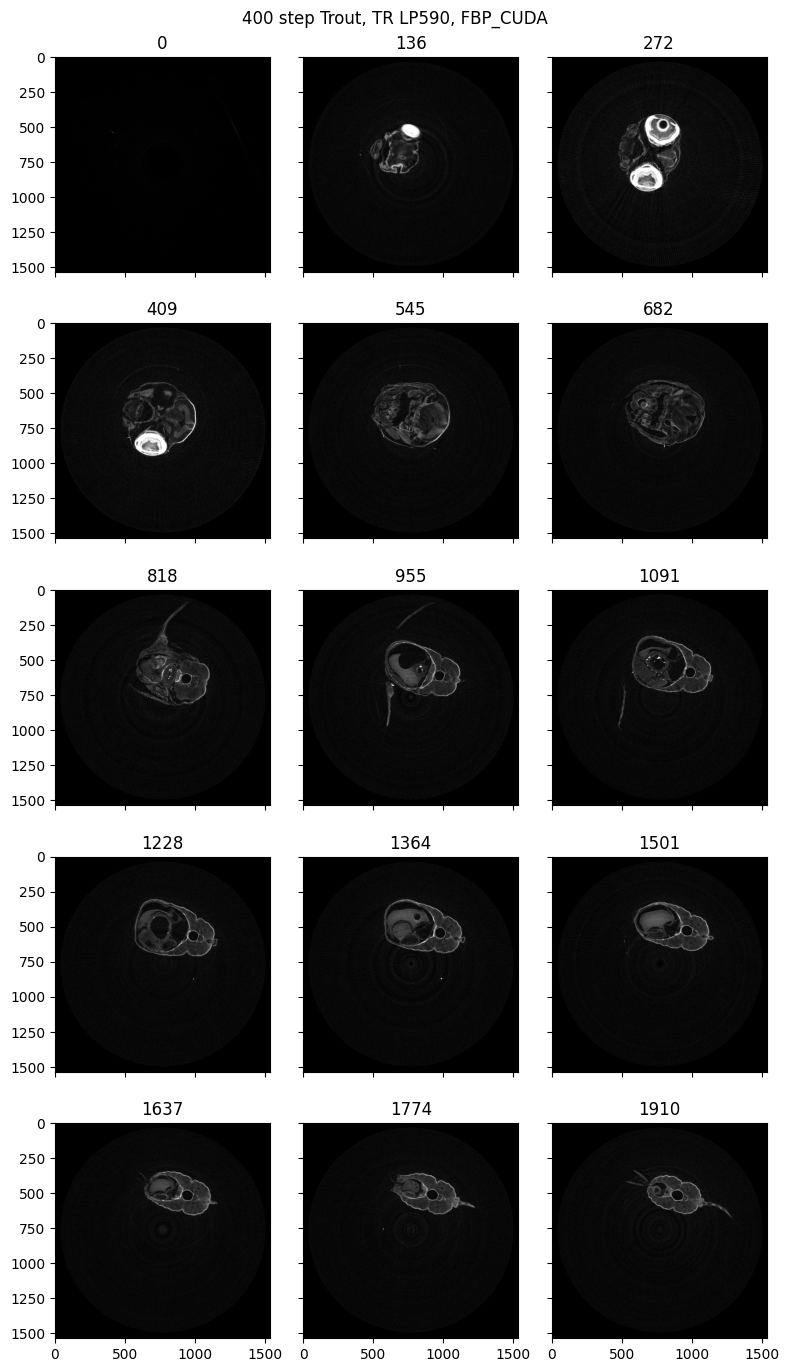

In [36]:
# Saturation factor
saturation_factor = 30
# same but normalize
cmax = np.amax(recon_fbp_cuda)
cmin = np.amin(recon_fbp_cuda)
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_fbp_cuda)):
    try:
        line = int(height/15*i)
        ax[i//3, i%3].imshow(recon_fbp_cuda[line],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin, vmax=cmax / saturation_factor)
        ax[i//3, i%3].set_title(line)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('fig_output/0801_trout_fbp-cuda_400_tr_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper Figure

In [46]:
lineidx = [200, 1000, 1500]
recon_fbp_cuda.shape

(2047, 1536, 1536)

In [47]:
# max projection alone
maxproj= np.max(recon_fbp_cuda, axis=2)

# normalization step
data = [recon_fbp_cuda[k] for k in lineidx]

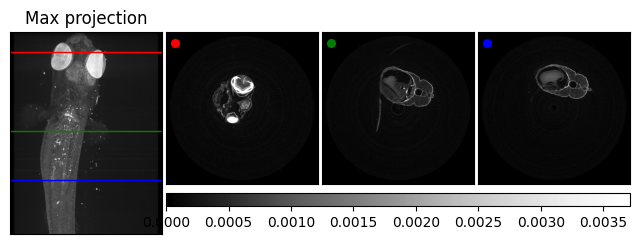

10381

In [48]:
import matplotlib.gridspec as gridspec

# saturation_factors
sf1 = 10
sf2 = 30
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(
    2, 4,
    height_ratios=[1.0, 0.032],
    width_ratios=[1.3, 1.3, 1.3, 1.3],
    hspace=-0.5
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[1, 1:])


ax0.imshow(maxproj, cmap=plt.cm.Greys_r,
           vmin=cmin, vmax=cmax / sf1)
ax0.axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax0.axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax0.axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax0.set_title('Max projection')
ax0.set_yticks([]), ax0.set_xticks([])


ax1.imshow(data[0], cmap=plt.cm.Greys_r,
           vmin=cmin, vmax=cmax / sf2)
ax1.scatter(90, 110, color="red", s=30)
ax1.set_yticks([]), ax1.set_xticks([])

ax2.imshow(data[1], cmap=plt.cm.Greys_r,
           vmin=cmin, vmax=cmax / sf2)
ax2.scatter(90, 110, color="green", s=30)
ax2.set_yticks([]), ax2.set_xticks([])

im = ax3.imshow(data[2], cmap=plt.cm.Greys_r,
                vmin=cmin, vmax=cmax / sf2)
ax3.scatter(90, 110, color="blue", s=30)
ax3.set_yticks([]), ax3.set_xticks([])
cbar = fig.colorbar(
    im,
    cax=cax,
    orientation="horizontal",
)
fig.subplots_adjust(
    hspace=0.02,
    wspace=0.03
)
u.move_up(ax1, 0.063)
u.move_up(ax2, 0.063)
u.move_up(ax3, 0.063)
u.move_up(cax, 0.09)

plt.savefig('fig_output/fig3b_tr.png', dpi=180)
plt.show()
gc.collect()

### Save recons and figure data
- this is optional, because the volumes are large, 8GB when casted to 16bit floats

In [34]:
# save data
data2save = u.data2saveFormat(recon_fbp_cuda)
print(sys.getsizeof(data2save), data2save.dtype)

with open('data_output/0801_tr_lp590_400_recon.npy', 'wb') as f:
    np.save(f, data2save)

9658957968 int16


In [50]:
# save the 3 slices used in the figure above for later comparison
# slices_paper_fl = np.array([data[k] for k in lineidx], dtype=np.float16)

dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('data_output/paper_recon_slices_tr.npy', 'wb') as f:
    np.save(f, dict2save)

In [35]:
# clean up again
try:
    del recon_fbp_cuda
except:
    pass

try:
    del data
except:
    pass

gc.collect()

87